In [ ]:
RAW_DIR = r"D:\Project\Leaf Class raw" # <-- change if needed
PROCESSED_DIR = r"D:\Project\Leaf Class\processed_all" # preprocessed + augmented saved here
DATASET_DIR = r"D:\Project\Leaf Class\dataset" # final train/val/test


IMAGE_SIZE = (224, 224) # model input size
TARGET_PER_CLASS = 600 # desired total images per class after augmentation (set None or <=0 to skip augmentation)


TRAIN_RATIO = 0.60
VAL_RATIO = 0.20
TEST_RATIO = 0.20


RANDOM_SEED = 42



In [28]:
import tensorflow as tf
print(tf.__version__)


ImportError: DLL load failed while importing _pywrap_custom_casts: The specified procedure could not be found.

In [29]:
# Imports
import os
import shutil
import random
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

ImportError: DLL load failed while importing _pywrap_custom_casts: The specified procedure could not be found.

In [4]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


# helper function
def is_image_file(fn):
    fn = fn.lower()
    return fn.endswith('.jpg') or fn.endswith('.jpeg') or fn.endswith('.png')



# make sure dirs exist
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)


# find classes in RAW_DIR
classes = [d for d in os.listdir(RAW_DIR) if os.path.isdir(os.path.join(RAW_DIR, d))]
classes.sort()
print(f"Found {len(classes)} classes: {classes}")

Found 12 classes: ['Artocarpus heterophyllus', 'Bambusa vulgaris', 'Coccinia grandis', 'Codiaeum variegatum', 'Ficus benghalensis', 'Foliorum Forma - Orbicularis', 'Herbarium Oxalis', 'Hevea brasiliensis', 'Indonesian Bay', 'Lembu', 'Mangifera indica', 'Psidium guajava']


In [5]:
# 1) Preprocess: resize & save all originals into PROCESSED_DIR/class_name
print('\n--- Preprocessing raw images (resize -> save) ---')
for cls in classes:
    src_dir = os.path.join(RAW_DIR, cls)
    dst_dir = os.path.join(PROCESSED_DIR, cls)
    os.makedirs(dst_dir, exist_ok=True)

    files = [f for f in os.listdir(src_dir) if is_image_file(f)]
    if not files:
        print(f"WARNING: no image files found for class {cls} in {src_dir}")
        continue

    for i, fname in enumerate(tqdm(files, desc=f"Preprocess {cls}")):
        src_path = os.path.join(src_dir, fname)
        dst_path = os.path.join(dst_dir, fname)

        try:
            img = Image.open(src_path).convert('RGB')
            img = img.resize(IMAGE_SIZE)
            img.save(dst_path)
        except Exception as e:
            print(f"Failed to process {src_path}: {e}")

print('Preprocessing complete.')



--- Preprocessing raw images (resize -> save) ---


Preprocess Psidium guajava: 100%|███████████████████████████████████████████████████| 303/303 [00:01<00:00, 266.00it/s]

Preprocessing complete.


In [6]:
import os
import shutil
import random
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [7]:
if TARGET_PER_CLASS and TARGET_PER_CLASS > 0:
    print('\n--- Augmenting images (saved) ---')

    # configure augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.08,
        height_shift_range=0.08,
        shear_range=0.08,
        zoom_range=0.12,
        brightness_range=(0.75, 1.25),
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for cls in classes:
        class_dir = os.path.join(PROCESSED_DIR, cls)
        if not os.path.isdir(class_dir):
            print(f"Skipping augmentation for {cls} (no processed folder)")
            continue

        # consider only 'original' preprocessed files as bases - avoid augmenting already-augmented files
        base_files = [f for f in os.listdir(class_dir) if is_image_file(f) and not f.startswith('aug_')]
        existing = [f for f in os.listdir(class_dir) if is_image_file(f)]
        existing_count = len(existing)

        if existing_count >= TARGET_PER_CLASS:
            print(f"{cls}: already {existing_count} images (>= target {TARGET_PER_CLASS}), skipping augmentation")
            continue

        n_to_generate = TARGET_PER_CLASS - existing_count
        print(f"{cls}: {existing_count} -> generate {n_to_generate} augmentations to reach {TARGET_PER_CLASS}")

        if not base_files:
            print(f"No base images found for {cls}, skipping")
            continue

        # generate augmentations by cycling through base_files
        idx = 0
        for k in tqdm(range(n_to_generate), desc=f"Augment {cls}"):
            base_fname = base_files[idx % len(base_files)]
            base_path = os.path.join(class_dir, base_fname)
            try:
                img = Image.open(base_path).convert('RGB')
                x = np.array(img)
                x = x.reshape((1,) + x.shape).astype('float32')

                save_prefix = f"aug_{k+1:05d}"
                gen = datagen.flow(
                    x,
                    batch_size=1,
                    save_to_dir=class_dir,
                    save_prefix=save_prefix,
                    save_format='jpg'
                )
                next(gen)  # create a single augmented image and save it
            except Exception as e:
                print(f"Failed augmenting {base_path}: {e}")
            idx += 1

    print('Augmentation complete.')

else:
    print('\n--- Augmentation skipped (TARGET_PER_CLASS not set) ---')



--- Augmenting images (saved) ---
Artocarpus heterophyllus: already 4392 images (>= target 600), skipping augmentation
Bambusa vulgaris: already 4500 images (>= target 600), skipping augmentation
Coccinia grandis: already 4428 images (>= target 600), skipping augmentation
Codiaeum variegatum: already 4260 images (>= target 600), skipping augmentation
Ficus benghalensis: already 4284 images (>= target 600), skipping augmentation
Foliorum Forma - Orbicularis: already 4416 images (>= target 600), skipping augmentation
Herbarium Oxalis: already 4260 images (>= target 600), skipping augmentation
Hevea brasiliensis: already 4368 images (>= target 600), skipping augmentation
Indonesian Bay: already 4224 images (>= target 600), skipping augmentation
Lembu: already 4260 images (>= target 600), skipping augmentation
Mangifera indica: already 4308 images (>= target 600), skipping augmentation
Psidium guajava: already 4236 images (>= target 600), skipping augmentation
Augmentation complete.


In [8]:
import os
import cv2
import albumentations as A

# --- Paths ---
RAW_DIR = r"D:\\Project\\Leaf Class raw"
PROCESSED_DIR = r"D:\\Project\\Leaf Class\\processed_all"

# Create processed directory if not exists
os.makedirs(PROCESSED_DIR, exist_ok=True)

# --- Augmentations ---
augmentations = {
    "brightness_contrast": A.RandomBrightnessContrast(p=1.0),
    "noise": A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
}

# --- Process each class ---
classes = [d for d in os.listdir(RAW_DIR) if os.path.isdir(os.path.join(RAW_DIR, d))]

for class_name in classes:
    input_folder = os.path.join(RAW_DIR, class_name)
    output_folder = os.path.join(PROCESSED_DIR, class_name)
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith((".jpg", ".png")):
            img_path = os.path.join(input_folder, filename)
            image = cv2.imread(img_path)
            name, ext = os.path.splitext(filename)

            if image is not None:
                # Convert to grayscale
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                cv2.imwrite(os.path.join(output_folder, f"grayscale_{name}.jpg"), gray_image)

                # Gaussian Blur
                blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
                cv2.imwrite(os.path.join(output_folder, f"blurred_{name}.jpg"), blurred_image)

                # Resize (224x224 for CNN input)
                resized_image = cv2.resize(image, (224, 224))
                cv2.imwrite(os.path.join(output_folder, f"resized_{name}.jpg"), resized_image)

                # Histogram Equalization
                hist_eq_image = cv2.equalizeHist(gray_image)
                cv2.imwrite(os.path.join(output_folder, f"hist_eq_{name}.jpg"), hist_eq_image)

                # Canny Edge Detection
                edges = cv2.Canny(image, 100, 200)
                cv2.imwrite(os.path.join(output_folder, f"edges_{name}.jpg"), edges)

                # Rotations
                rotations = {
                    "rot_90": cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE),
                    "rot_180": cv2.rotate(image, cv2.ROTATE_180),
                    "rot_270": cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE),
                }
                for rot_name, rot_image in rotations.items():
                    cv2.imwrite(os.path.join(output_folder, f"{rot_name}_{name}.jpg"), rot_image)

                # Flipping
                flipped_images = {
                    "flip_horizontal": cv2.flip(image, 1),
                    "flip_vertical": cv2.flip(image, 0),
                }
                for flip_name, flip_image in flipped_images.items():
                    cv2.imwrite(os.path.join(output_folder, f"{flip_name}_{name}.jpg"), flip_image)

                # Apply Albumentations augmentations
                for aug_name, aug in augmentations.items():
                    augmented = aug(image=image)
                    augmented_image = augmented["image"]
                    cv2.imwrite(os.path.join(output_folder, f"{aug_name}_{name}.jpg"), augmented_image)

print("✅ Preprocessing and Augmentation Completed! Saved in processed_all")


C:\Users\Mahfuj\AppData\Local\Temp\ipykernel_20172\991223164.py:15: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  "noise": A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),


KeyboardInterrupt: 

In [ ]:
print('\n--- Creating train/val/test splits ---')
assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-6, 'Ratios must sum to 1.0'

for cls in classes:
    src_dir = os.path.join(PROCESSED_DIR, cls)
    files = [f for f in os.listdir(src_dir) if is_image_file(f)]
    random.shuffle(files)

    n = len(files)
    n_train = int(n * TRAIN_RATIO)
    n_val = int(n * VAL_RATIO)

    train_files = files[:n_train]
    val_files = files[n_train:n_train + n_val]
    test_files = files[n_train + n_val:]

    for split_name, split_files in [('train', train_files), ('val', val_files), ('test', test_files)]:
        out_dir = os.path.join(DATASET_DIR, split_name, cls)
        os.makedirs(out_dir, exist_ok=True)
        for fn in split_files:
            shutil.copy2(os.path.join(src_dir, fn), os.path.join(out_dir, fn))

print('Splitting complete.')

# %%
print('\n--- Dataset summary ---')
for cls in classes:
    proc_dir = os.path.join(PROCESSED_DIR, cls)
    proc_count = len([f for f in os.listdir(proc_dir) if is_image_file(f)])

    train_count = len(os.listdir(os.path.join(DATASET_DIR, 'train', cls))) if os.path.isdir(os.path.join(DATASET_DIR, 'train', cls)) else 0
    val_count = len(os.listdir(os.path.join(DATASET_DIR, 'val', cls))) if os.path.isdir(os.path.join(DATASET_DIR, 'val', cls)) else 0
    test_count = len(os.listdir(os.path.join(DATASET_DIR, 'test', cls))) if os.path.isdir(os.path.join(DATASET_DIR, 'test', cls)) else 0

    print(f"{cls}: processed_total={proc_count:4d} -> train={train_count:4d}, val={val_count:4d}, test={test_count:4d}")

print('\nAll done. Canny-augmented images saved in:', PROCESSED_DIR)
print('Train/Val/Test dataset saved in:', DATASET_DIR)


In [ ]:
import matplotlib.pyplot as plt
import cv2, os, random
import math

SAMPLE_PER_CLASS = 3  # how many per class
NUM_CLASSES_TO_SHOW = min(6, len(classes))  # adjust how many classes to display

selected_classes = random.sample(classes, NUM_CLASSES_TO_SHOW)
total_images = NUM_CLASSES_TO_SHOW * SAMPLE_PER_CLASS

# Calculate grid size
cols = SAMPLE_PER_CLASS
rows = math.ceil(total_images / cols)

plt.figure(figsize=(15, 3 * rows))  # adjust height based on rows
i = 1

for class_name in selected_classes:
    class_folder = os.path.join(PROCESSED_DIR, class_name)
    images = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.png'))]

    for img_name in random.sample(images, min(SAMPLE_PER_CLASS, len(images))):
        img_path = os.path.join(class_folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue  # skip unreadable images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.title(f"{class_name[:15]}\n{img_name[:20]}")
        plt.axis("off")
        i += 1

plt.tight_layout()
plt.show()



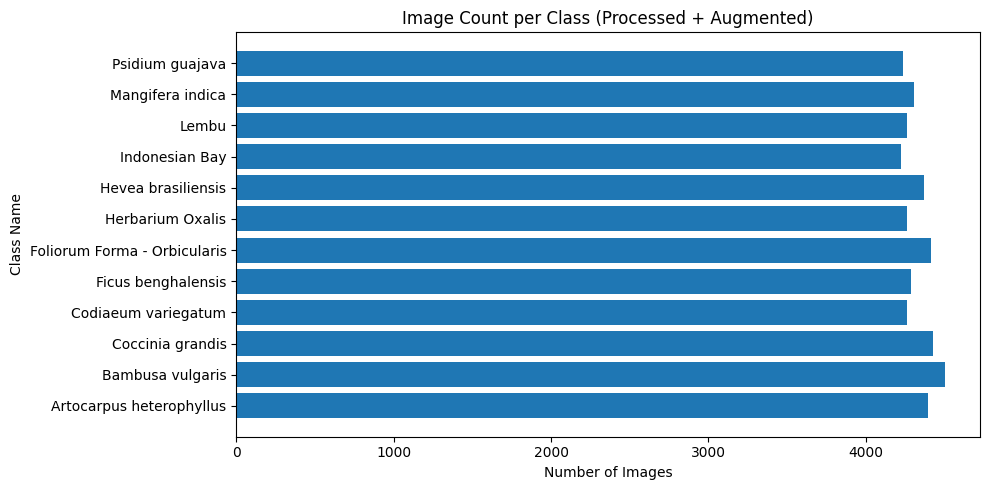

In [9]:
import matplotlib.pyplot as plt

class_counts = {}

for cls in classes:
    class_dir = os.path.join(PROCESSED_DIR, cls)
    class_counts[cls] = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))])

plt.figure(figsize=(10,5))
plt.barh(list(class_counts.keys()), list(class_counts.values()))
plt.title("Image Count per Class (Processed + Augmented)")
plt.xlabel("Number of Images")
plt.ylabel("Class Name")
plt.tight_layout()
plt.show()


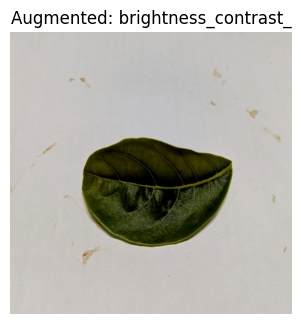

In [12]:
cls = random.choice(classes)
class_dir = os.path.join(PROCESSED_DIR, cls)
samples = [f for f in os.listdir(class_dir) if 'brightness_contrast' in f or 'noise' in f]

if samples:
    sample_name = random.choice(samples)
    original_name = sample_name.split('_', 1)[-1]
    original_path = os.path.join(class_dir, original_name) if os.path.exists(os.path.join(class_dir, original_name)) else None

    aug_img = cv2.imread(os.path.join(class_dir, sample_name))
    aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 4))
    if original_path:
        orig_img = cv2.imread(original_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 2, 1)
        plt.imshow(orig_img)
        plt.title("Original")
        plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(aug_img)
    plt.title(f"Augmented: {sample_name[:20]}")
    plt.axis("off")
    plt.show()


In [13]:
import numpy as np

sizes = []
for cls in classes:
    for f in os.listdir(os.path.join(PROCESSED_DIR, cls)):
        img_path = os.path.join(PROCESSED_DIR, cls, f)
        img = cv2.imread(img_path)
        if img is not None:
            sizes.append(img.shape[:2])

sizes = np.array(sizes)
unique_sizes = np.unique(sizes, axis=0)
print(f"Unique image sizes found: {unique_sizes}")


KeyboardInterrupt: 

In [25]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [26]:
base_dir = r"D:\Project\Leaf Class\dataset"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 31157 images belonging to 12 classes.
Found 10383 images belonging to 12 classes.
Found 10396 images belonging to 12 classes.


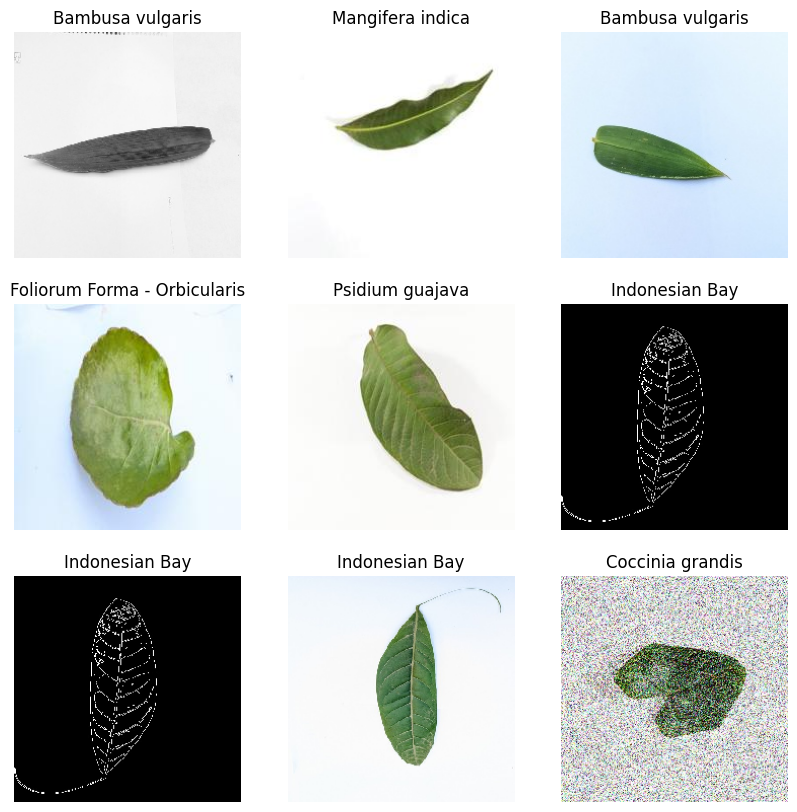

In [27]:
x_batch, y_batch = next(train_data)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    plt.title(list(train_data.class_indices.keys())[y_batch[i].argmax()])
    plt.axis('off')
plt.show()


In [ ]:
#CNN

In [ ]:
num_classes = len(train_data.class_indices)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*img_size, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)


In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.legend()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc*100:.2f}%")


In [ ]:
model.save("leaf_classifier_model.h5")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# Get the true labels
true_labels = test_data.classes
class_names = list(test_data.class_indices.keys())

# Predict
pred_probs = model.predict(test_data)
pred_labels = np.argmax(pred_probs, axis=1)


In [ ]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix with Class Labels')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:")
print(report)


In [ ]:
#Mobilenetv2

In [28]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# --- Callbacks ---
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- Base Model ---
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze base layers

# --- Custom Classifier on top ---
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# --- Final Model ---
model = Model(inputs=base_model.input, outputs=outputs)

# --- Compile ---
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- Train ---
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=[lr_reduction, early_stop]
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,589,004 (9.88 MB)

 Trainable params: 331,020 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 320s 326ms/step - accuracy: 0.8229 - loss: 0.5863 - val_accuracy: 0.9484 - val_loss: 0.1964 - learning_rate: 1.0000e-04
Epoch 2/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 328s 336ms/step - accuracy: 0.9380 - loss: 0.2044 - val_accuracy: 0.9670 - val_loss: 0.1253 - learning_rate: 1.0000e-04
Epoch 3/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 317s 325ms/step - accuracy: 0.9555 - loss: 0.1462 - val_accuracy: 0.9726 - val_loss: 0.1009 - learning_rate: 1.0000e-04
Epoch 4/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 316s 325ms/step - accuracy: 0.9640 - loss: 0.1157 - val_accuracy: 0.9759 - val_loss: 0.0854 - learning_rate: 1.0000e-04
Epoch 5/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 326s 335ms/step - accuracy: 0.9707 - loss: 0.0963 - val_accuracy: 0.9774 - val_loss: 0.0780 - learning_rate: 1.0000e-04
Epoch 6/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 321s 329ms/step - accuracy: 0.9746 - loss: 0.0826 - val_accuracy: 0.9793 - val_loss: 0.0688 - learning_rate: 1.0000e-04
Epoch 7/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 

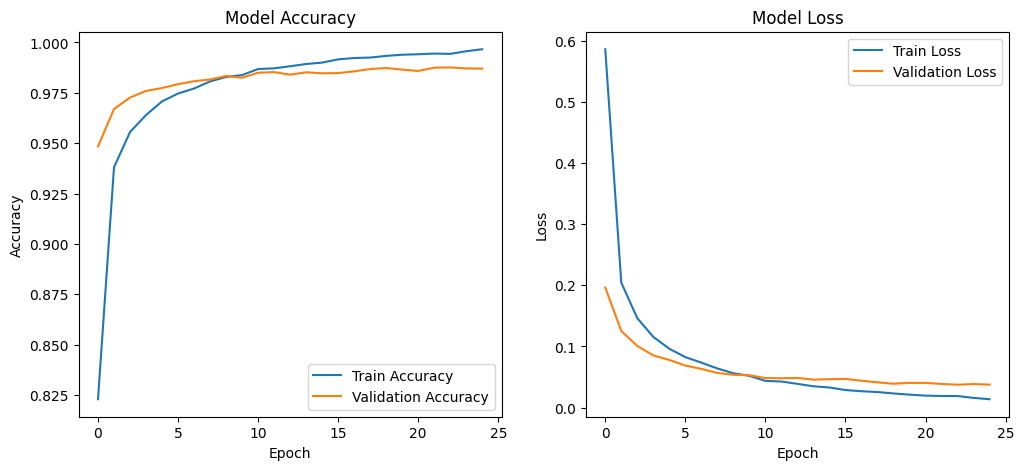

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#plt.grid(True)

# Loss curve
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.grid(True)

plt.show()


In [30]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")

325/325 ━━━━━━━━━━━━━━━━━━━━ 233s 717ms/step - accuracy: 0.9879 - loss: 0.0363
Test Accuracy: 98.79% | Test Loss: 0.0363


325/325 ━━━━━━━━━━━━━━━━━━━━ 81s 248ms/step


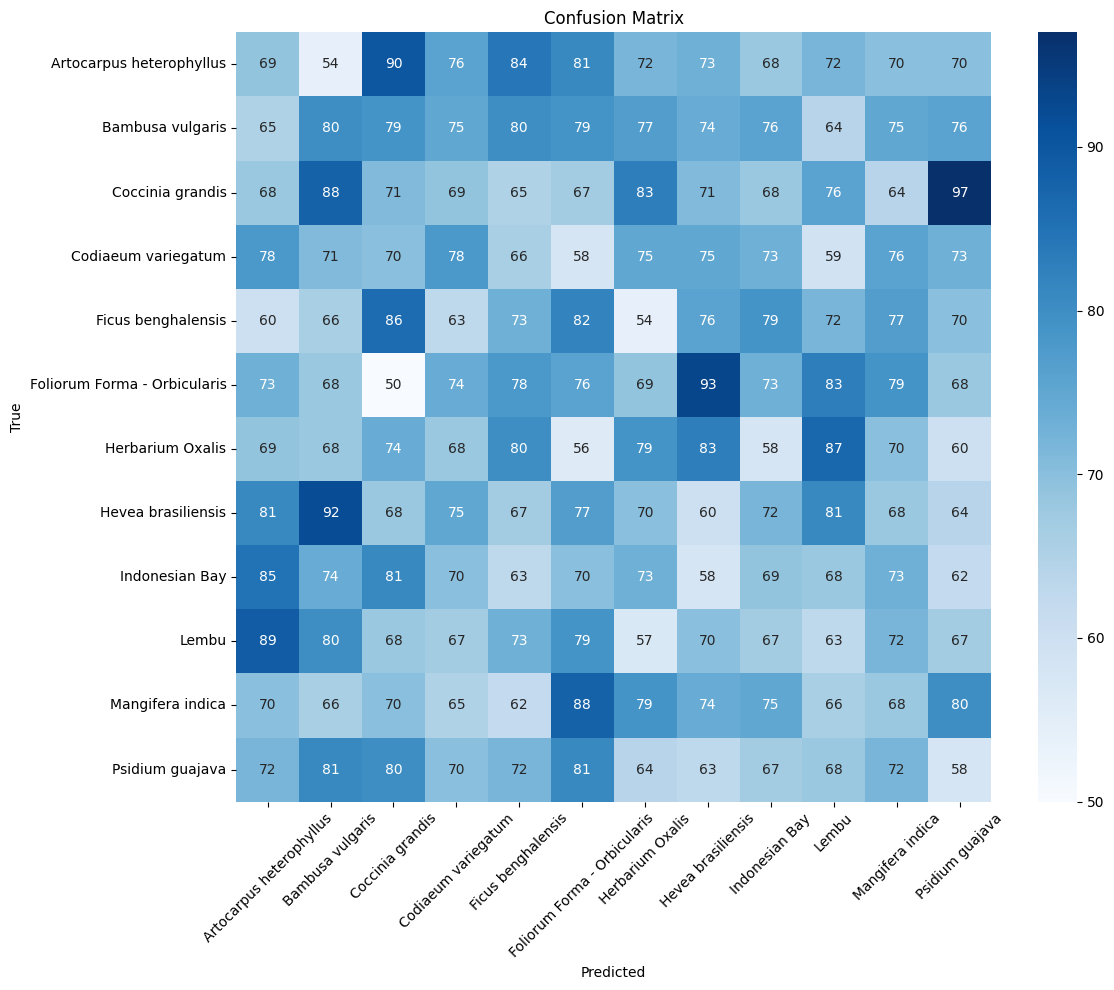


Classification Report:

                              precision    recall  f1-score   support

    Artocarpus heterophyllus       0.08      0.08      0.08       879
            Bambusa vulgaris       0.09      0.09      0.09       900
            Coccinia grandis       0.08      0.08      0.08       887
         Codiaeum variegatum       0.09      0.09      0.09       852
          Ficus benghalensis       0.08      0.09      0.08       858
Foliorum Forma - Orbicularis       0.09      0.09      0.09       884
            Herbarium Oxalis       0.09      0.09      0.09       852
          Hevea brasiliensis       0.07      0.07      0.07       875
              Indonesian Bay       0.08      0.08      0.08       846
                       Lembu       0.07      0.07      0.07       852
            Mangifera indica       0.08      0.08      0.08       863
             Psidium guajava       0.07      0.07      0.07       848

                    accuracy                           0.08    

In [31]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict on test data
true_labels = test_data.classes
class_names = list(test_data.class_indices.keys())

pred_probs = model.predict(test_data)
pred_labels = np.argmax(pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_names))


In [32]:
# Save the trained MobileNetV2 model
model.save('D:/Project/Leaf_Model/mobilenetv2_leaf_classifier2.h5')
print("✅ Model saved successfully at: D:/Project/Leaf_Model/mobilenetv2_leaf_classifier.h5")


✅ Model saved successfully at: D:/Project/Leaf_Model/mobilenetv2_leaf_classifier.h5


In [15]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model(r"D:/Project/Leaf_Model/mobilenetv2_leaf_classifier.h5")
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [ ]:
D:\Project\Leaf Class raw\TestLeaf.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Found 10396 images belonging to 12 classes.
🪴 Predicted Class: Artocarpus heterophyllus


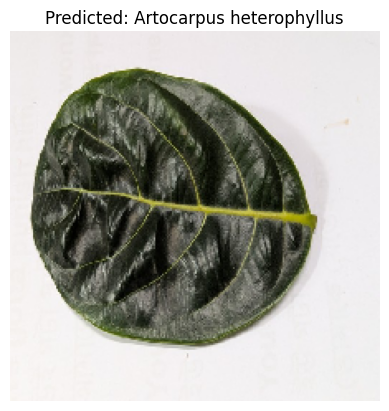

In [16]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Path to the image you want to test
img_path = r"D:\Project\Leaf Class raw\Artocarpus heterophyllus_331.jpg"

# Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))  # same size as training input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # normalization

# Predict
prediction = model.predict(img_array)

# Get class index
# If you used ImageDataGenerator.flow_from_directory, class indices are stored in .class_indices
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_direct
predicted_class = np.argmax(prediction, axis=1)[0]
ory(
    r"D:\Project\Leaf Class\dataset\test",  # path to your test folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
class_labels = list(test_gen.class_indices.keys())

print("🪴 Predicted Class:", class_labels[predicted_class])

# Show the image
plt.imshow(img)
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.axis("off")
plt.show()


In [ ]:
aug_00030_0_1824

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Found 10396 images belonging to 12 classes.
🪴 Predicted Class: Ficus benghalensis


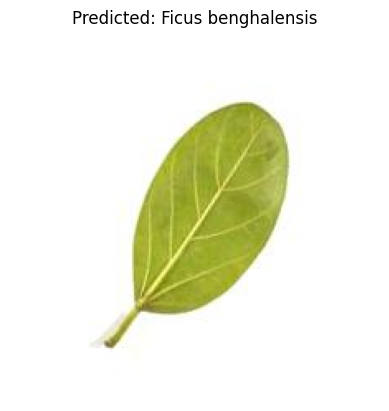

In [17]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Path to the image you want to test
img_path = r"D:\Project\Leaf Class raw\aug_00030_0_1824.jpg"

# Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))  # same size as training input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # normalization

# Predict
prediction = model.predict(img_array)

# Get class index
predicted_class = np.argmax(prediction, axis=1)[0]

# If you used ImageDataGenerator.flow_from_directory, class indices are stored in .class_indices
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    r"D:\Project\Leaf Class\dataset\test",  # path to your test folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
class_labels = list(test_gen.class_indices.keys())

print("🪴 Predicted Class:", class_labels[predicted_class])

# Show the image
plt.imshow(img)
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.axis("off")
plt.show()


In [ ]:
#ShuffleNetV2

In [33]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np


In [34]:
IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_gen.class_indices)


Found 31157 images belonging to 12 classes.
Found 10383 images belonging to 12 classes.
Found 10396 images belonging to 12 classes.


In [35]:
base_model = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/shufflenet_v2_1_0_224/feature_vector/5",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    trainable=False  # fine-tune later if needed
)


OSError: https://tfhub.dev/tensorflow/shufflenet_v2_1_0_224/feature_vector/5 does not appear to be a valid module.

In [ ]:
import tensorflow_hub as hub

base_model = hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5",
    input_shape=(224, 224, 3),
    trainable=False
)




In [ ]:
model = Sequential([
    base_model,
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


In [36]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model

# Set number of classes for your classification problem
num_classes = 12  # 👈 Change this to match your dataset

# Load the base model
base_model = hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5",
    input_shape=(224, 224, 3),
    trainable=False
)

# Define the model using Functional API
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model.summary()


ValueError: Exception encountered when calling layer 'keras_layer' (type KerasLayer).

A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

Call arguments received by layer 'keras_layer' (type KerasLayer):
  • inputs=<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1200>
  • training=None

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25
)


In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.legend()
plt.show()


In [ ]:
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
#EfficientNetV2-B0

In [18]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os


In [19]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_gen.class_indices)


NameError: name 'train_dir' is not defined

In [37]:
# Define the dataset paths
train_dir = r"D:\Project\Leaf Class\dataset\train"
val_dir = r"D:\Project\Leaf Class\dataset\val"
test_dir = r"D:\Project\Leaf Class\dataset\test"

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_gen.class_indices)


Found 31157 images belonging to 12 classes.
Found 10383 images belonging to 12 classes.
Found 10396 images belonging to 12 classes.


In [38]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# --- Callbacks ---
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- Base Model ---
base_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze base layers initially

# --- Custom Classifier on top ---
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# --- Final Model ---
model = Model(inputs=base_model.input, outputs=outputs)

# --- Compile ---
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- Train ---
history = model.fit(
    train_gen,                    # <-- use train_gen here
    validation_data=val_gen,     # <-- use val_gen here
    epochs=25,
    callbacks=[lr_reduction, early_stop]
)



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_2 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_2               │ (None, 224, 224, 3)       │               0 │ rescaling_2[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ normalization_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 112, 112, 16)      │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 112, 112, 16)      │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 112, 112, 16)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 56, 56, 64)        │           9,216 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_bn             │ (None, 56, 56, 64)        │             256 │ block2a_expand_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_activation     │ (None, 56, 56, 64)        │               0 │ block2a_expand_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_conv (Conv2D) │ (None, 56, 56, 32)        │           2,048 │ block2a_expand_activation… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_bn            │ (None, 56, 56, 32)        │             128 │ block2a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 6,250,332 (23.84 MB)

 Trainable params: 331,020 (1.26 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

C:\Users\Mahfuj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 1446s 1s/step - accuracy: 0.0841 - loss: 2.4901 - val_accuracy: 0.0867 - val_loss: 2.4849 - learning_rate: 1.0000e-04
Epoch 2/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 496s 509ms/step - accuracy: 0.0846 - loss: 2.4851 - val_accuracy: 0.0841 - val_loss: 2.4848 - learning_rate: 1.0000e-04
Epoch 3/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 472s 485ms/step - accuracy: 0.0851 - loss: 2.4850 - val_accuracy: 0.0891 - val_loss: 2.4846 - learning_rate: 1.0000e-04
Epoch 4/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 475s 488ms/step - accuracy: 0.0866 - loss: 2.4849 - val_accuracy: 0.0867 - val_loss: 2.4848 - learning_rate: 1.0000e-04
Epoch 5/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 471s 483ms/step - accuracy: 0.0868 - loss: 2.4849 - val_accuracy: 0.0867 - val_loss: 2.4848 - learning_rate: 1.0000e-04
Epoch 6/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.0860 - loss: 2.4849
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
974/974 ━━━━━━━━━━━━━━━━━━━━ 483s 496m

In [39]:
base_model = hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    trainable=False  # you can fine-tune later
)


In [40]:
model = Sequential([
    base_model,
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x0000024DBF54B940> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [ ]:
#MobileViT

In [41]:
# Define the dataset paths
train_dir = r"D:\Project\Leaf Class\dataset\train"
val_dir = r"D:\Project\Leaf Class\dataset\val"
test_dir = r"D:\Project\Leaf Class\dataset\test"

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_gen.class_indices)


Found 31157 images belonging to 12 classes.
Found 10383 images belonging to 12 classes.
Found 10396 images belonging to 12 classes.


In [50]:
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras_cv.models import MobileViT

# --- Parameters ---
num_classes = 12  # Number of leaf classes
IMG_SIZE = (224, 224)

# --- Callbacks ---
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- Base Model (MobileViT - Fine-Tunable) ---
# You can choose variants: "xxs", "xs", or "s"
base_model = MobileViT(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    classes=num_classes,
    variant="xs"   # 'xxs' = ultra small, 'xs' = small, 's' = standard
)

# Make all layers trainable for full fine-tuning
base_model.trainable = True

# --- Custom Classifier on top ---
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# --- Final Model ---
model = Model(inputs=base_model.input, outputs=outputs)

# --- Compile ---
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Summary ---
model.summary()

# --- Train ---
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=[lr_reduction, early_stop]
)

# --- Save Model ---
model.save("D:/Project/Leaf_Model/mobilevit_xs_finetuned_leaf_classifier.h5")


ImportError: cannot import name 'MobileViT' from 'keras_cv.models' (C:\Users\Mahfuj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_cv\api\models\__init__.py)

In [49]:
from keras_cv.models import MobileViT

model = MobileViT.from_preset("mobilevit_xs", input_shape=(224, 224, 3), num_classes=12)
model.summary()


ImportError: cannot import name 'MobileViT' from 'keras_cv.models' (C:\Users\Mahfuj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_cv\api\models\__init__.py)